### Set up

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import nibabel.freesurfer.io as fsio
from nilearn import datasets, plotting
import random


In [21]:
random.seed(42)
np.random.seed(42)

In [22]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_FIS_no_outliers.csv', index_col=0)

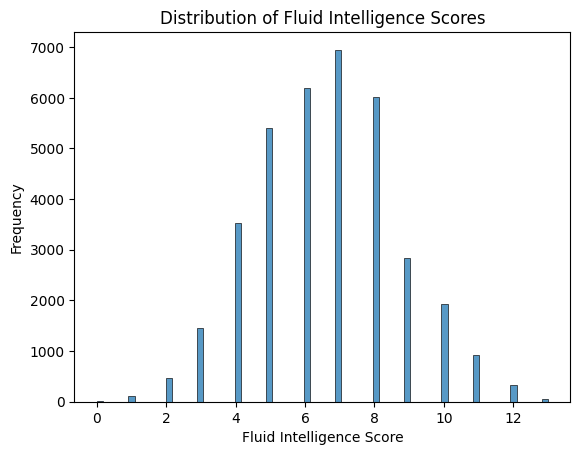

In [23]:
# Histogram of Fluid Intelligence Scores
sns.histplot(df['20016-2.0'])
plt.title('Distribution of Fluid Intelligence Scores')
plt.xlabel('Fluid Intelligence Score')
plt.ylabel('Frequency')
plt.show()

In [24]:
print(len(df))
print(df.shape)

36203
(36203, 134)


### Using MIND to predict Fluid Intelligence Score

In [26]:
# Set X and y

X = df[['31-0.0', '21003-2.0', '54-2.0',
        
        'lh_bankssts', 'lh_caudalanteriorcingulate', 'lh_caudalmiddlefrontal',
        'lh_cuneus', 'lh_entorhinal', 'lh_fusiform', 'lh_inferiorparietal', 
        'lh_inferiortemporal', 'lh_isthmuscingulate', 'lh_lateraloccipital', 
        'lh_lateralorbitofrontal', 'lh_lingual', 'lh_medialorbitofrontal', 
        'lh_middletemporal', 'lh_parahippocampal', 'lh_paracentral', 
        'lh_parsopercularis', 'lh_parsorbitalis', 'lh_parstriangularis', 
        'lh_pericalcarine', 'lh_postcentral', 'lh_posteriorcingulate', 
        'lh_precentral', 'lh_precuneus', 'lh_rostralanteriorcingulate', 
        'lh_rostralmiddlefrontal', 'lh_superiorfrontal', 'lh_superiorparietal', 
        'lh_superiortemporal', 'lh_supramarginal', 'lh_frontalpole', 
        'lh_temporalpole', 'lh_transversetemporal', 'lh_insula', 
        'rh_bankssts', 'rh_caudalanteriorcingulate', 'rh_caudalmiddlefrontal', 
        'rh_cuneus', 'rh_entorhinal', 'rh_fusiform', 'rh_inferiorparietal', 
        'rh_inferiortemporal', 'rh_isthmuscingulate', 'rh_lateraloccipital', 
        'rh_lateralorbitofrontal', 'rh_lingual', 'rh_medialorbitofrontal', 
        'rh_middletemporal', 'rh_parahippocampal', 'rh_paracentral', 
        'rh_parsopercularis', 'rh_parsorbitalis', 'rh_parstriangularis', 
        'rh_pericalcarine', 'rh_postcentral', 'rh_posteriorcingulate', 
        'rh_precentral', 'rh_precuneus', 'rh_rostralanteriorcingulate', 
        'rh_rostralmiddlefrontal', 'rh_superiorfrontal', 'rh_superiorparietal', 
        'rh_superiortemporal', 'rh_supramarginal', 'rh_frontalpole', 
        'rh_temporalpole', 'rh_transversetemporal', 'rh_insula']]

y = df['20016-2.0']

In [27]:
# rename columns
datafield_code = ['31-0.0', '21003-2.0', '54-2.0']

datafield_name = ['sex', 'age', 'assessment centre']

if len(datafield_code) == len(datafield_name):
    rename_dict = dict(zip(datafield_code, datafield_name))
    X = X.rename(columns=rename_dict)
    print("Columns renamed successfully.")
else:
    print("Error: The number of datafield codes does not match the number of datafield names.")

categorical_vars = ['sex', 'assessment centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

preprocessor = ColumnTransformer(transformers=[
    # scale continuous features
    ('num', StandardScaler(), continuous_vars),
    # one-hot encode the assessment centre (drop one level to avoid collinearity)
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars),
])

Columns renamed successfully.


In [28]:
# Cross-validation set-up
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)

outer_mae, outer_rmse, outer_r2 = [], [], []
best_params_per_fold = []
nonzero_predictors = []
coefs_list = []

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Inner CV
    pipe = Pipeline(steps=[
        ('preproc', preprocessor),
        ('elasticnetcv', ElasticNetCV(
            l1_ratio=np.linspace(0.3,0.9,7),
            alphas=np.logspace(-4,2,20),
            cv=20, max_iter=5000, random_state=42))
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # --- metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    outer_mae.append(mae)
    outer_rmse.append(rmse)
    outer_r2.append(r2)

    # --- store best α & l1_ratio for this fold ---
    est = pipe['elasticnetcv']
    best_params_per_fold.append(
        {'alpha': est.alpha_, 'l1_ratio': est.l1_ratio_}
    )

    # --- predictors that survived ---
    coefs = est.coef_
    coefs_list.append(coefs)
    surviving = [col for col, c in zip(X.columns, coefs) if c != 0]
    nonzero_predictors.append(surviving)

    print(f'Fold {fold:02d} • MAE={mae:.3f} • RMSE={rmse:.3f} • R²={r2:.3f} '
          f'• α={est.alpha_:.4g} • l1_ratio={est.l1_ratio_:.2f}')
    

# Aggregate results
print('\n=== 20-fold CV summary ===')
print(f'Mean MAE :  {np.mean(outer_mae):.3f}  ± {np.std(outer_mae):.3f}')
print(f'Mean RMSE:  {np.mean(outer_rmse):.3f} ± {np.std(outer_rmse):.3f}')
print(f'Mean R²  :  {np.mean(outer_r2):.3f}  ± {np.std(outer_r2):.3f}')



Fold 01 • MAE=1.640 • RMSE=2.041 • R²=0.031 • α=0.007848 • l1_ratio=0.30
Fold 02 • MAE=1.631 • RMSE=2.037 • R²=0.041 • α=0.007848 • l1_ratio=0.30
Fold 03 • MAE=1.615 • RMSE=2.022 • R²=0.034 • α=0.007848 • l1_ratio=0.30
Fold 04 • MAE=1.639 • RMSE=2.027 • R²=0.029 • α=0.007848 • l1_ratio=0.30
Fold 05 • MAE=1.660 • RMSE=2.069 • R²=0.026 • α=0.003793 • l1_ratio=0.90
Fold 06 • MAE=1.605 • RMSE=2.012 • R²=0.030 • α=0.003793 • l1_ratio=0.80
Fold 07 • MAE=1.641 • RMSE=2.033 • R²=0.038 • α=0.007848 • l1_ratio=0.30
Fold 08 • MAE=1.599 • RMSE=1.998 • R²=0.028 • α=0.007848 • l1_ratio=0.40
Fold 09 • MAE=1.615 • RMSE=2.004 • R²=0.033 • α=0.007848 • l1_ratio=0.50
Fold 10 • MAE=1.629 • RMSE=2.019 • R²=0.038 • α=0.007848 • l1_ratio=0.50

=== 20-fold CV summary ===
Mean MAE :  1.627  ± 0.018
Mean RMSE:  2.026 ± 0.019
Mean R²  :  0.033  ± 0.005


In [10]:
# View parameter choices & surviving variables
param_df = pd.DataFrame(best_params_per_fold)
print('\nBest α and l1_ratio per fold\n', param_df)

print('\nVariables that kept non-zero coefficients in ≥1 fold:')
print(sorted({v for fold_vars in nonzero_predictors for v in fold_vars}))


Best α and l1_ratio per fold
       alpha  l1_ratio
0  0.007848       0.5
1  0.007848       0.4
2  0.007848       0.4
3  0.007848       0.4
4  0.016238       0.3
5  0.007848       0.4
6  0.007848       0.4
7  0.007848       0.5
8  0.016238       0.3
9  0.016238       0.3

Variables that kept non-zero coefficients in ≥1 fold:
['age', 'assessment centre', 'lh_bankssts', 'lh_caudalanteriorcingulate', 'lh_caudalmiddlefrontal', 'lh_cuneus', 'lh_entorhinal', 'lh_frontalpole', 'lh_fusiform', 'lh_inferiortemporal', 'lh_insula', 'lh_isthmuscingulate', 'lh_lateralorbitofrontal', 'lh_lingual', 'lh_medialorbitofrontal', 'lh_middletemporal', 'lh_paracentral', 'lh_parahippocampal', 'lh_parsopercularis', 'lh_parsorbitalis', 'lh_parstriangularis', 'lh_pericalcarine', 'lh_postcentral', 'lh_posteriorcingulate', 'lh_precentral', 'lh_rostralanteriorcingulate', 'lh_rostralmiddlefrontal', 'lh_superiorfrontal', 'lh_superiorparietal', 'lh_superiortemporal', 'lh_supramarginal', 'lh_temporalpole', 'lh_transver

In [ ]:
# Final refit on all data
final_model = make_pipeline(
    StandardScaler(),
    ElasticNetCV(
        l1_ratio=np.linspace(0.3, 0.9, 7),
        alphas=np.logspace(-4, 2, 20),
        cv=20,
        max_iter=5000,
        random_state=42
    )
).fit(X, y)

print('\n=== Final model ===')
print(f"α  = {final_model.named_steps['elasticnetcv'].alpha_:.4g}")
print(f"l1 = {final_model.named_steps['elasticnetcv'].l1_ratio_:.2f}")

In [ ]:
# Variable-survival summary
flat_survivors  = [v for fold in nonzero_predictors for v in fold]
survivor_counts = Counter(flat_survivors)

print('\n► Number of folds each variable survived')
for var, ct in survivor_counts.items():
    print(f'{var}: {ct}/{len(nonzero_predictors)}')

# print("\n► Survived in >50% of folds")
# for var, ct in survivor_counts.items():
#     if ct > len(nonzero_predictors) / 2:
#         print(var)

# print("\n► Survived in **all** folds")
# for var, ct in survivor_counts.items():
#     if ct == len(nonzero_predictors):
#         print(var)


In [ ]:
print(len(nonzero_predictors))
print(np.array(coefs_list).shape)

In [ ]:
# Coefficient mean ± 95 % CI
coefs = np.vstack(coefs_list)
#print(coefs.shape)
mean_coefs = coefs.mean(axis=0)
std_coefs = coefs.std(axis=0, ddof=1)
ci95 = 1.96 * std_coefs / np.sqrt(coefs.shape[0])

surv_mask = (coefs != 0).any(axis=0)
surv_vars = np.array(X.columns)[surv_mask]

print('\n► 95% CIs for survivors')
for n, m, ci in zip(
        surv_vars, mean_coefs[surv_mask], ci95[surv_mask]):
    print(f"{n}: {m:.3f} ± {ci:.3f}")



In [ ]:
# Bar-plot of coefficient means + CIs
if len(surv_vars):
    order = np.argsort(np.abs(mean_coefs[surv_mask]))[::-1]
    plt.figure(figsize=(10, 0.35 * len(order) + 2))
    plt.barh(
        surv_vars[order],
        mean_coefs[surv_mask][order],
        xerr=ci95[surv_mask][order],
        capsize=5,
        ecolor='black',
    )
    plt.axvline(0, c='grey', ls='--')
    plt.xlabel('Mean coefficient (±95 % CI)')
    plt.title('Elastic Net | non-zero predictors across folds')
    plt.tight_layout()
    plt.show()

else:
    print("Nothing to plot ‒ no variables ever survived.")

In [ ]:
# Strict survivors (CI never crosses zero)
low = mean_coefs - ci95
high = mean_coefs + ci95
strict_mask = surv_mask & ((low > 0) | (high < 0))

strict_vars = X.columns[strict_mask]
print(f"\n► {strict_mask.sum()} variables whose 95% CI never crosses 0:")
for n, m, l, h in zip(
        strict_vars,
        mean_coefs[strict_mask],
        low[strict_mask],
        high[strict_mask]):
    print(f"  {n}: {m:.3f}  ({l:.3f} – {h:.3f})")

In [ ]:
# Re-fit elastic net *only* on strict survivors
if strict_vars.size == 0:
    print("\n⚠️  No strict survivors, skipping refit.")
else:
    X_strict = X[strict_vars]

    outer_cv = KFold(n_splits=20, shuffle=True, random_state=42)
    outer_mae, outer_rmse, outer_r2 = [], [], []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_strict, y), start=1):
        X_strict_train, X_strict_test = X_strict.iloc[train_idx], X_strict.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipe = make_pipeline(
            StandardScaler(),
            ElasticNetCV(
                l1_ratio=np.linspace(0.3, 0.9, 7),
                alphas=np.logspace(-4, 2, 20),
                cv=20,
                max_iter=5000,
                random_state=42
            )
        )

        pipe.fit(X_strict_train, y_train)
        y_pred = pipe.predict(X_strict_test)

        # --- metrics ---
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        outer_mae.append(mae)
        outer_rmse.append(rmse)
        outer_r2.append(r2)

        # --- store best α & l1_ratio for this fold ---
        est = pipe.named_steps['elasticnetcv']

        print(f'Fold {fold:02d} • MAE={mae:.3f} • RMSE={rmse:.3f} • R²={r2:.3f} '
              f'• α={est.alpha_:.4g} • l1_ratio={est.l1_ratio_:.2f}')

    print("\n=== Re-fit on strict survivors (20-fold CV) ===")
    print(f"MAE : {np.mean(mae):.3f} ± {np.std(mae):.3f}")
    print(f"RMSE: {np.mean(rmse):.3f} ± {np.std(rmse):.3f}")
    print(f"R²  : {np.mean(r2):.3f} ± {np.std(r2):.3f}")

In [ ]:
# 1. Variable names and coefficients
if 'strict_vars' in globals() and len(strict_vars):
    vars_to_plot = np.array(strict_vars)
    means = mean_coefs[strict_mask]
    # cis = ci95[strict_mask]
else:
    vars_to_plot = surv_vars
    means = mean_coefs[surv_mask]
    # cis = ci95[surv_mask]

# 2. Set FreeSurfer fsaverage path
fsaverage_path = '/Applications/freesurfer/subjects/fsaverage'

# 3. Load annotation files
lh_annot = fsio.read_annot(f'{fsaverage_path}/label/lh.aparc.annot')
rh_annot = fsio.read_annot(f'{fsaverage_path}/label/rh.aparc.annot')
lh_labels, lh_cmap, lh_names = lh_annot
rh_labels, rh_cmap, rh_names = rh_annot
lh_names = [name.decode('utf-8') for name in lh_names]
rh_names = [name.decode('utf-8') for name in rh_names]

# 4. Prepare vertex data arrays
lh_vertex_data = np.full_like(lh_labels, np.nan, dtype=float)
rh_vertex_data = np.full_like(rh_labels, np.nan, dtype=float)

def varname_to_region(var):
    if var.startswith('lh_'):
        return 'lh', var.replace('lh_', '').replace('_thickness', '')
    elif var.startswith('rh_'):
        return 'rh', var.replace('rh_', '').replace('_thickness', '').replace('.', '')
    return None, None

for var, coef in zip(vars_to_plot, means):
    hemi, region = varname_to_region(var)
    if hemi == 'lh':
        idxs = [i for i, n in enumerate(lh_names) if region.lower() in n.lower()]
        for idx in idxs:
            lh_vertex_data[lh_labels == idx] = coef
    elif hemi == 'rh':
        idxs = [i for i, n in enumerate(rh_names) if region.lower() in n.lower()]
        for idx in idxs:
            rh_vertex_data[rh_labels == idx] = coef

# 5. Load inflated_pre surfaces
lh_inflated_pre_path = f'{fsaverage_path}/surf/lh.inflated_pre'
rh_inflated_pre_path = f'{fsaverage_path}/surf/rh.inflated_pre'
lh_coords, lh_faces = fsio.read_geometry(lh_inflated_pre_path)
rh_coords, rh_faces = fsio.read_geometry(rh_inflated_pre_path)
lh_mesh = (lh_coords, lh_faces)
rh_mesh = (rh_coords, rh_faces)

# 6. Load fsaverage sulcal maps for background
fsavg = datasets.fetch_surf_fsaverage('fsaverage')
sulc_left = fsavg.sulc_left
sulc_right = fsavg.sulc_right

# 7. Plotting function
global_vmax = np.nanmax(np.abs(np.concatenate([lh_vertex_data, rh_vertex_data])))

def plot_three_views_custom(surf_mesh, vertex_data, bg_map, hemi, title):
    views = ['lateral', 'medial', 'dorsal']
    fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(40, 20))
    cmap = 'seismic'
    for i, view in enumerate(views):
        plotting.plot_surf_stat_map(
            surf_mesh, vertex_data, hemi=hemi, bg_map=bg_map,
            cmap=cmap, colorbar=False, vmax=global_vmax, vmin=-global_vmax, symmetric_cbar=True,
            view=view, axes=axes[i], title='', figure=fig, alpha=0.9
        )
        axes[i].set_title(view.capitalize(), fontsize=30)
        axes[i].axis('off')
    # Colorbar
    cbar_ax = fig.add_axes([0.33, 0.09, 0.34, 0.03])
    norm = plt.Normalize(vmin=-global_vmax, vmax=global_vmax)
    cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal')
    cb.set_label('Mean Coefficient Values', fontsize=16)
    cb.ax.tick_params(labelsize=18)
    plt.suptitle(title, fontsize=38, y=0.96)
    plt.tight_layout(rect=[0, 0.15, 1, 0.92])
    plt.show()

# 8. Plot with inflated_pre
plot_three_views_custom(lh_mesh, lh_vertex_data, sulc_left, 'left', 'Left Hemisphere (Demographic + MIND)')
plot_three_views_custom(rh_mesh, rh_vertex_data, sulc_right, 'right', 'Right Hemisphere (Demographic + MIND)')


### Using Cortical Thickness to predict Fluid Intelligence Score

In [ ]:
X = df[['31-0.0', '21003-2.0',
        
        '27174-2.0', '27267-2.0', '27175-2.0', '27268-2.0', '27176-2.0', '27269-2.0', '27177-2.0',
        '27270-2.0', '27178-2.0', '27271-2.0', '27179-2.0', '27272-2.0', '27180-2.0', '27273-2.0',
        '27204-2.0', '27297-2.0', '27181-2.0', '27274-2.0', '27182-2.0', '27275-2.0', '27183-2.0',
        '27276-2.0', '27184-2.0', '27277-2.0', '27185-2.0', '27278-2.0', '27186-2.0', '27279-2.0',
        '27188-2.0', '27281-2.0', '27187-2.0', '27280-2.0', '27189-2.0', '27282-2.0', '27190-2.0',
        '27283-2.0', '27191-2.0', '27284-2.0', '27192-2.0', '27285-2.0', '27193-2.0', '27286-2.0',
        '27194-2.0', '27287-2.0', '27195-2.0', '27288-2.0', '27196-2.0', '27289-2.0', '27197-2.0',
        '27290-2.0', '27198-2.0', '27291-2.0', '27199-2.0', '27292-2.0', '27200-2.0', '27293-2.0',
        '27201-2.0', '27294-2.0', '27202-2.0', '27295-2.0', '27203-2.0', '27296-2.0']]

y = df['20016-2.0']

In [ ]:

datafield_code = ['31-0.0', '21003-2.0',
    
        '27174-2.0', '27267-2.0', '27175-2.0', '27268-2.0', '27176-2.0', '27269-2.0', '27177-2.0',
        '27270-2.0', '27178-2.0', '27271-2.0', '27179-2.0', '27272-2.0', '27180-2.0', '27273-2.0',
        '27204-2.0', '27297-2.0', '27181-2.0', '27274-2.0', '27182-2.0', '27275-2.0', '27183-2.0',
        '27276-2.0', '27184-2.0', '27277-2.0', '27185-2.0', '27278-2.0', '27186-2.0', '27279-2.0',
        '27188-2.0', '27281-2.0', '27187-2.0', '27280-2.0', '27189-2.0', '27282-2.0', '27190-2.0',
        '27283-2.0', '27191-2.0', '27284-2.0', '27192-2.0', '27285-2.0', '27193-2.0', '27286-2.0',
        '27194-2.0', '27287-2.0', '27195-2.0', '27288-2.0', '27196-2.0', '27289-2.0', '27197-2.0',
        '27290-2.0', '27198-2.0', '27291-2.0', '27199-2.0', '27292-2.0', '27200-2.0', '27293-2.0',
        '27201-2.0', '27294-2.0', '27202-2.0', '27295-2.0', '27203-2.0', '27296-2.0']

datafield_name = ['sex', 'age',
    
        'lh_caudalanteriorcingulate_thickness', 'rh_caudalanteriorcingulate_thickness', 'lh_caudalmiddlefrontal_thickness',
        'rh_caudalmiddlefrontal_thickness', 'lh_cuneus_thickness', 'rh_cuneus_thickness', 'lh_entorhinal_thickness', 
        'rh_entorhinal_thickness', 'lh_fusiform_thickness', 'rh_fusiform_thickness', 'lh_inferiorparietal_thickness', 
        'rh_inferiorparietal_thickness', 'lh_inferiortemporal_thickness', 'rh_inferiortemporal_thickness', 'lh_insula_thickness', 
        'rh_insula_thickness', 'lh_isthmuscingulate_thickness', 'rh_isthmuscingulate_thickness', 'lh_lateraloccipital_thickness', 
        'rh_lateraloccipital_thickness', 'lh_lateralorbitofrontal_thickness', 'rh_lateralorbitofrontal_thickness', 
        'lh_lingual_thickness', 'rh_lingual_thickness', 'lh_medialorbitofrontal_thickness', 'rh_medialorbitofrontal_thickness', 
        'lh_middletemporal_thickness', 'rh_middletemporal_thickness', 'lh_paracentral_thickness', 'rh_paracentral_thickness', 
        'lh_parahippocampal_thickness', 'rh_parahippocampal_thickness', 'lh_parsopercularis_thickness', 'rh_parsopercularis_thickness', 
        'lh_parsorbitalis_thickness', 'rh_parsorbitalis_thickness', 'lh_parstriangularis_thickness', 'rh_parstriangularis_thickness', 
        'lh_pericalcarine_thickness', 'rh_pericalcarine_thickness', 'lh_postcentral_thickness', 'rh_postcentral_thickness', 
        'lh_posteriorcingulate_thickness', 'rh_posteriorcingulate_thickness', 'lh_precentral_thickness', 'rh_precentral_thickness', 
        'lh_precuneus_thickness', 'rh_precuneus_thickness', 'lh_rostralanteriorcingulate_thickness', 'rh_rostralanteriorcingulate_thickness', 
        'lh_rostralmiddlefrontal_thickness', 'rh_rostralmiddlefrontal_thickness', 'lh_superiorfrontal_thickness', 'rh_superiorfrontal_thickness', 
        'lh_superiorparietal_thickness', 'rh_superiorparietal_thickness', 'lh_superiortemporal_thickness', 'rh_superiortemporal_thickness', 
        'lh_supramarginal_thickness', 'rh_supramarginal_thickness', 'lh_transversetemporal_thickness', 'rh_transversetemporal_thickness']

print(len(datafield_code) == len(datafield_name))

rename_dict = dict(zip(datafield_code, datafield_name))
X = X.rename(columns=rename_dict)

In [ ]:
# Cross-validation set-up
outer_cv = KFold(n_splits=20, shuffle=True, random_state=42)

outer_mae, outer_rmse, outer_r2 = [], [], []
best_params_per_fold = []
nonzero_predictors = []
coefs_list = []

for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Inner CV
    pipe = make_pipeline(
        StandardScaler(),
        ElasticNetCV(
            l1_ratio=np.linspace(0.3, 0.9, 7),
            alphas=np.logspace(-4, 2, 20),
            cv=20,
            max_iter=5000,
            random_state=42
        )
    )

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # --- metrics ---
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    outer_mae.append(mae)
    outer_rmse.append(rmse)
    outer_r2.append(r2)

    # --- store best α & l1_ratio for this fold ---
    est = pipe.named_steps['elasticnetcv']
    best_params_per_fold.append(
        {'alpha': est.alpha_, 'l1_ratio': est.l1_ratio_}
    )

    # --- predictors that survived ---
    coefs = est.coef_
    coefs_list.append(coefs)
    surviving = [col for col, c in zip(X.columns, coefs) if c != 0]
    nonzero_predictors.append(surviving)

    print(f'Fold {fold:02d} • MAE={mae:.3f} • RMSE={rmse:.3f} • R²={r2:.3f} '
          f'• α={est.alpha_:.4g} • l1_ratio={est.l1_ratio_:.2f}')
    

# Aggregate results
print('\n=== 20-fold CV summary ===')
print(f'Mean MAE :  {np.mean(outer_mae):.3f}  ± {np.std(outer_mae):.3f}')
print(f'Mean RMSE:  {np.mean(outer_rmse):.3f} ± {np.std(outer_rmse):.3f}')
print(f'Mean R²  :  {np.mean(outer_r2):.3f}  ± {np.std(outer_r2):.3f}')



In [ ]:
# View parameter choices & surviving variables
param_df = pd.DataFrame(best_params_per_fold)
print('\nBest α and l1_ratio per fold\n', param_df)

print('\nVariables that kept non-zero coefficients in ≥1 fold:')
print(sorted({v for fold_vars in nonzero_predictors for v in fold_vars}))

In [ ]:
# Final refit on all data
final_model = make_pipeline(
    StandardScaler(),
    ElasticNetCV(
        l1_ratio=np.linspace(0.3, 0.9, 7),
        alphas=np.logspace(-4, 2, 20),
        cv=20,
        max_iter=5000,
        random_state=42
    )
).fit(X, y)

print('\n=== Final model ===')
print(f"α  = {final_model.named_steps['elasticnetcv'].alpha_:.4g}")
print(f"l1 = {final_model.named_steps['elasticnetcv'].l1_ratio_:.2f}")

In [ ]:
# Variable-survival summary
flat_survivors  = [v for fold in nonzero_predictors for v in fold]
survivor_counts = Counter(flat_survivors)

print('\n► Number of folds each variable survived')
for var, ct in survivor_counts.items():
    print(f'{var}: {ct}/{len(nonzero_predictors)}')

# print("\n► Survived in >50% of folds")
# for var, ct in survivor_counts.items():
#     if ct > len(nonzero_predictors) / 2:
#         print(var)

# print("\n► Survived in **all** folds")
# for var, ct in survivor_counts.items():
#     if ct == len(nonzero_predictors):
#         print(var)


In [ ]:
print(len(nonzero_predictors))
print(np.array(coefs_list).shape)

In [ ]:
# Coefficient mean ± 95 % CI
coefs = np.vstack(coefs_list)
#print(coefs.shape)
mean_coefs = coefs.mean(axis=0)
std_coefs = coefs.std(axis=0, ddof=1)
ci95 = 1.96 * std_coefs / np.sqrt(coefs.shape[0])

surv_mask = (coefs != 0).any(axis=0)
surv_vars = np.array(X.columns)[surv_mask]

print('\n► 95% CIs for survivors')
for n, m, ci in zip(
        surv_vars, mean_coefs[surv_mask], ci95[surv_mask]):
    print(f"{n}: {m:.3f} ± {ci:.3f}")



In [ ]:
# Bar-plot of coefficient means + CIs
if len(surv_vars):
    order = np.argsort(np.abs(mean_coefs[surv_mask]))[::-1]
    plt.figure(figsize=(10, 0.35 * len(order) + 2))
    plt.barh(
        surv_vars[order],
        mean_coefs[surv_mask][order],
        xerr=ci95[surv_mask][order],
        capsize=5,
        ecolor='black',
    )
    plt.axvline(0, c='grey', ls='--')
    plt.xlabel('Mean coefficient (±95 % CI)')
    plt.title('Elastic Net | non-zero predictors across folds')
    plt.tight_layout()
    plt.show()

else:
    print("Nothing to plot ‒ no variables ever survived.")

In [ ]:
# Strict survivors (CI never crosses zero)
low = mean_coefs - ci95
high = mean_coefs + ci95
strict_mask = surv_mask & ((low > 0) | (high < 0))

strict_vars = X.columns[strict_mask]
print(f"\n► {strict_mask.sum()} variables whose 95% CI never crosses 0:")
for n, m, l, h in zip(
        strict_vars,
        mean_coefs[strict_mask],
        low[strict_mask],
        high[strict_mask]):
    print(f"  {n}: {m:.3f}  ({l:.3f} – {h:.3f})")

In [ ]:
# Re-fit elastic net *only* on strict survivors
if strict_vars.size == 0:
    print("\n⚠️  No strict survivors, skipping refit.")
else:
    X_strict = X[strict_vars]

    outer_cv = KFold(n_splits=20, shuffle=True, random_state=42)
    outer_mae, outer_rmse, outer_r2 = [], [], []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_strict, y), start=1):
        X_strict_train, X_strict_test = X_strict.iloc[train_idx], X_strict.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipe = make_pipeline(
            StandardScaler(),
            ElasticNetCV(
                l1_ratio=np.linspace(0.3, 0.9, 7),
                alphas=np.logspace(-4, 2, 20),
                cv=20,
                max_iter=5000,
                random_state=42
            )
        )

        pipe.fit(X_strict_train, y_train)
        y_pred = pipe.predict(X_strict_test)

        # --- metrics ---
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        outer_mae.append(mae)
        outer_rmse.append(rmse)
        outer_r2.append(r2)

        # --- store best α & l1_ratio for this fold ---
        est = pipe.named_steps['elasticnetcv']

        print(f'Fold {fold:02d} • MAE={mae:.3f} • RMSE={rmse:.3f} • R²={r2:.3f} '
              f'• α={est.alpha_:.4g} • l1_ratio={est.l1_ratio_:.2f}')

    print("\n=== Re-fit on strict survivors (20-fold CV) ===")
    print(f"MAE : {np.mean(mae):.3f} ± {np.std(mae):.3f}")
    print(f"RMSE: {np.mean(rmse):.3f} ± {np.std(rmse):.3f}")
    print(f"R²  : {np.mean(r2):.3f} ± {np.std(r2):.3f}")

In [ ]:
# 1. Variable names and coefficients
if 'strict_vars' in globals() and len(strict_vars):
    vars_to_plot = np.array(strict_vars)
    means = mean_coefs[strict_mask]
    # cis = ci95[strict_mask]
else:
    vars_to_plot = surv_vars
    means = mean_coefs[surv_mask]
    # cis = ci95[surv_mask]

# 2. Set FreeSurfer fsaverage path
fsaverage_path = '/Applications/freesurfer/subjects/fsaverage'

# 3. Load annotation files
lh_annot = fsio.read_annot(f'{fsaverage_path}/label/lh.aparc.annot')
rh_annot = fsio.read_annot(f'{fsaverage_path}/label/rh.aparc.annot')
lh_labels, lh_cmap, lh_names = lh_annot
rh_labels, rh_cmap, rh_names = rh_annot
lh_names = [name.decode('utf-8') for name in lh_names]
rh_names = [name.decode('utf-8') for name in rh_names]

# 4. Prepare vertex data arrays
lh_vertex_data = np.full_like(lh_labels, np.nan, dtype=float)
rh_vertex_data = np.full_like(rh_labels, np.nan, dtype=float)

def varname_to_region(var):
    if var.startswith('lh_'):
        return 'lh', var.replace('lh_', '').replace('_thickness', '')
    elif var.startswith('rh_'):
        return 'rh', var.replace('rh_', '').replace('_thickness', '').replace('.', '')
    return None, None

for var, coef in zip(vars_to_plot, means):
    hemi, region = varname_to_region(var)
    if hemi == 'lh':
        idxs = [i for i, n in enumerate(lh_names) if region.lower() in n.lower()]
        for idx in idxs:
            lh_vertex_data[lh_labels == idx] = coef
    elif hemi == 'rh':
        idxs = [i for i, n in enumerate(rh_names) if region.lower() in n.lower()]
        for idx in idxs:
            rh_vertex_data[rh_labels == idx] = coef

# 5. Load inflated_pre surfaces
lh_inflated_pre_path = f'{fsaverage_path}/surf/lh.inflated_pre'
rh_inflated_pre_path = f'{fsaverage_path}/surf/rh.inflated_pre'
lh_coords, lh_faces = fsio.read_geometry(lh_inflated_pre_path)
rh_coords, rh_faces = fsio.read_geometry(rh_inflated_pre_path)
lh_mesh = (lh_coords, lh_faces)
rh_mesh = (rh_coords, rh_faces)

# 6. Load fsaverage sulcal maps for background
fsavg = datasets.fetch_surf_fsaverage('fsaverage')
sulc_left = fsavg.sulc_left
sulc_right = fsavg.sulc_right

# 7. Plotting function
global_vmax = np.nanmax(np.abs(np.concatenate([lh_vertex_data, rh_vertex_data])))

def plot_three_views_custom(surf_mesh, vertex_data, bg_map, hemi, title):
    views = ['lateral', 'medial', 'dorsal']
    fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(40, 20))
    cmap = 'seismic'
    for i, view in enumerate(views):
        plotting.plot_surf_stat_map(
            surf_mesh, vertex_data, hemi=hemi, bg_map=bg_map,
            cmap=cmap, colorbar=False, vmax=global_vmax, vmin=-global_vmax, symmetric_cbar=True,
            view=view, axes=axes[i], title='', figure=fig, alpha=0.9
        )
        axes[i].set_title(view.capitalize(), fontsize=30)
        axes[i].axis('off')
    # Colorbar
    cbar_ax = fig.add_axes([0.33, 0.09, 0.34, 0.03])
    norm = plt.Normalize(vmin=-global_vmax, vmax=global_vmax)
    cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal')
    cb.set_label('Mean Coefficient Values', fontsize=16)
    cb.ax.tick_params(labelsize=18)
    plt.suptitle(title, fontsize=38, y=0.96)
    plt.tight_layout(rect=[0, 0.15, 1, 0.92])
    plt.show()

# 8. Plot with inflated_pre
plot_three_views_custom(lh_mesh, lh_vertex_data, sulc_left, 'left', 'Left Hemisphere (Demographic + Cortical Thickness)')
plot_three_views_custom(rh_mesh, rh_vertex_data, sulc_right, 'right', 'Right Hemisphere (Demographic + Cortical Thickness)')
